# Visualize AFOG Attack on Swin-L
This notebook provides tools for visualizing an AFOG attack on a single image for Swin-L. Please following setup instructions in README.md prior to running this notebook.

In [1]:
import os
import sys
sys.path.append(os.getcwd()[:os.getcwd().find("demos")])
import torch, json
import numpy as np

from scripts.attack_dino import build_model_main
from utils.dino_utils.slconfig import SLConfig
from utils.dataset_utils.coco import build_dataset
from utils.dino_utils.visualizer import COCOVisualizer
from utils.dino_utils import box_ops
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

Choose the locations for the Swin checkpoint and config path. NOTE: change model_checkpoint_path to the filename on your system.

In [2]:
model_config_path = "../utils/dino_utils/config/DINO/DINO_4scale_swin.py"
model_checkpoint_path = "../model_files/checkpoint0011_4scale_swin.pth"

Load in model and prepare dataset.

In [3]:
args = SLConfig.fromfile(model_config_path) 
args.device = 'cuda' 
model, criterion, postprocessors = build_model_main(args)
checkpoint = torch.load(model_checkpoint_path, map_location='cpu')
model.criterion = criterion
model.postprocessors = postprocessors
_ = model.eval()
model.load_state_dict(checkpoint['model'])
model.to(torch.device('cuda'))
# load coco names
with open('../utils/dino_utils/coco_id2name.json') as f:
    id2name = json.load(f)
    id2name = {int(k):v for k,v in id2name.items()}
    
args.dataset_file = 'coco'
args.coco_path = "../datasets/coco/" # the path of coco
args.fix_size = False

dataset_val = build_dataset(image_set='val', args=args)   

/home/hice1/zyahn3/.conda/envs/AFOG/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


use_checkpoint!!!!!!!!!!!!!!!!!!!!!!!!


/home/hice1/zyahn3/.conda/envs/AFOG/lib/python3.12/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789220573/work/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/scratch/951431/ipykernel_3502325/3536615921.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mo

loading annotations into memory...
Done (t=0.38s)
creating index...
index created!


Helper functions for preparing and attacking a single image.

In [14]:
# Visualize the ground-truth labels
def viz_gt(image, targets):
    box_label = [id2name[int(item)] for item in targets['labels']]
    gt_dict = {
        'boxes': targets['boxes'],
        'image_id': targets['image_id'],
        'size': targets['size'],
        'box_label': box_label,
    }
    vslzr = COCOVisualizer()
    vslzr.visualize(image, gt_dict, savedir=None, caption="Ground Truth")

# Visualize model predictions
def viz_preds(model, image, targets, caption):
    output = model(image[None].cuda())
    output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]

    threshold = 0.5 # set a threshold

    scores = output['scores']
    labels = output['labels']
    boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
    select_mask = scores > threshold
    box_label = [id2name[int(item)] for item in labels[select_mask]]
    pred_dict = {
        'boxes': boxes[select_mask],
        'size': targets['size'],
        'box_label': box_label
    }
    vslzr = COCOVisualizer()
    vslzr.visualize(image, pred_dict, savedir=None, caption=caption)

from matplotlib.cm import coolwarm
def visualize_attack(model, image, targets, attack, mode, n_iter=5):
    x_adv, etas, eta_grads, map_grads, maps = attack(model, image.unsqueeze(0).float(), vis=True, n_iter = n_iter, mode="baseline")
    
    print([(np.max(m), np.min(m)) for m in maps])
    
    # normalize grads to make them easier to see
    perts = np.multiply(etas, maps)
    perts_norm = [(grad - np.min(grad)) / (np.max(grad) - np.min(grad)) for grad in perts]
    perts_norm = [np.clip(1 - np.abs(pert - np.median(pert)), 0, 1) for pert in perts_norm]
    
    eta_grads_norm = [(grad - np.min(grad)) / (np.max(grad)-np.min(grad)) for grad in eta_grads]
    eta_grads_norm = [np.clip(1 - 5*np.abs(grad - np.median(grad)), 0, 1) for grad in eta_grads_norm]
    
    map_grads_norm = [(grad - np.min(grad)) / (0.001 + np.max(grad)-np.min(grad)) for grad in map_grads]
    map_grads_norm = [np.clip(1 - 5*np.abs(grad - np.median(grad)), 0, 1) for grad in map_grads_norm]
    
    etas_norm = [(eta - np.min(eta)) / (np.max(eta)-np.min(eta)) for eta in etas]
    etas_norm = [100 * np.clip(1 - np.abs(eta - np.median(eta)), 0, 1) for eta in etas_norm]
    
    maps_norm = [(m - np.min(m)) / (0.001 + np.max(m)-np.min(m)) for m in maps]
    maps_norm = [np.clip(1 - np.abs(m - np.median(m)), 0, 1) for m in maps_norm]
    
    
    fig, ax = plt.subplots(nrows=n_iter, ncols=5, figsize=(15, n_iter*3+8))

    for i in range(n_iter):
        colormap = "RdYlBu"
        ax[i][0].matshow(perts_norm[i].squeeze()[0, :, :], cmap=colormap)
        ax[i][1].matshow(eta_grads_norm[i].squeeze()[0, :, :], cmap=colormap)
        ax[i][2].matshow(maps_norm[i].squeeze()[0, :, :], cmap=colormap)
        ax[i][3].matshow(map_grads_norm[i].squeeze()[0, :, :], cmap=colormap)
        ax[i][4].matshow(etas_norm[i].squeeze()[0, :, :], cmap=colormap)

        ax[i][0].set_title("After Iter " + str(i+1) + ": A*P")
        ax[i][1].set_title("P Grad")
        ax[i][2].set_title("A Map")
        ax[i][3].set_title("A Grad")
        ax[i][4].set_title("P")
    plt.show()
    print(etas[0].shape)

Select an image from the dataset. Display the ground truth labels and the benign predictions from Swin.

--- Image ID: 421060 ---


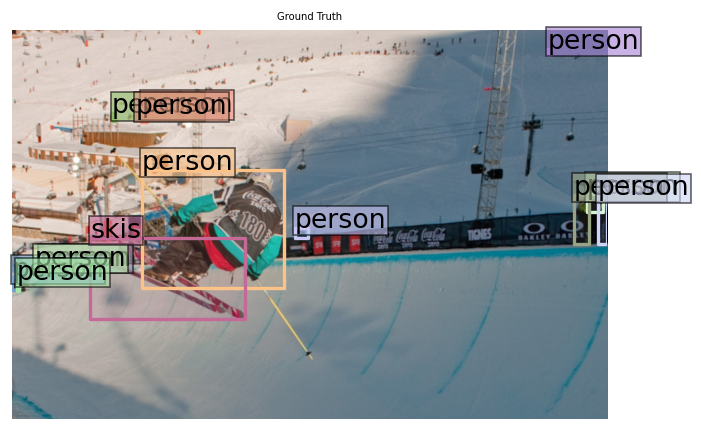

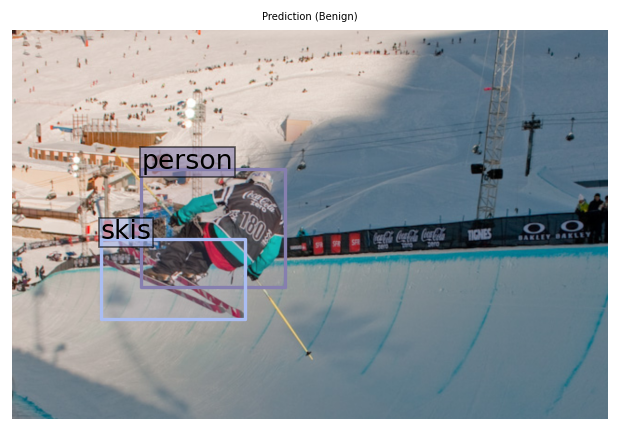

In [26]:
IM_NUM=3635

image, targets = dataset_val[IM_NUM]
print("--- Image ID:", targets["image_id"][0].item(), "---")
viz_gt(image, targets)
viz_preds(model, image, targets, caption="Prediction (Benign)")

Attack the image with AFOG and display the adversarial predictions. Attack mode can be changed by setting mode to either "baseline", "vanishing", or "fabrication"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.018635303..1.0189667].


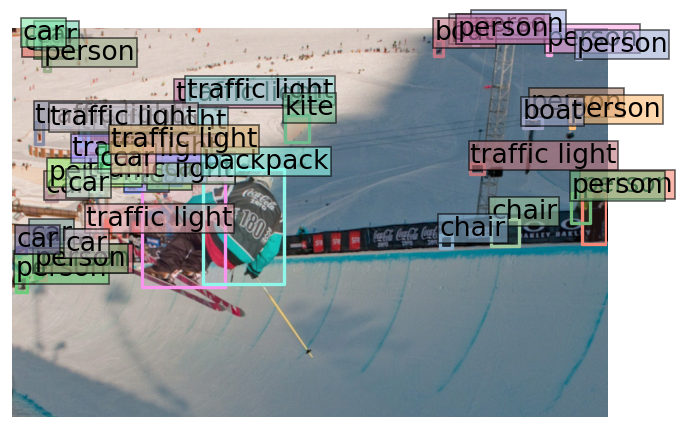

In [28]:
from afog.attacks import *
image_unt = afog(model, image.unsqueeze(0).float(), n_iter=10, mode="baseline")

viz_preds(model, image_unt.squeeze().float(), targets, caption="")

Visualize the internals of AFOG as it iterates, including perturbation map, attention map, and their gradients.

In [ ]:
#image, targets = dataset_val[0]
visualize_attack(model, image, targets, afog, "baseline", n_iter=10)
%matplotlib inline